In [1]:
# https://github.com/pytorch/examples/blob/master/imagenet/main.py

In [2]:
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from fastai.vision.models.xresnet import *

In [3]:
from fastai.basics import *

In [4]:
cudnn.benchmark = True

In [5]:
path = untar_data(URLs.IMAGENETTE_320)
BATCH_SIZE = 32
NUM_WORKERS = 8
LR = 8e-3

WEIGHT_DECAY=1e-2
NUM_EPOCHS=5

In [6]:
traindir = os.path.join(path, 'train')
valdir = os.path.join(path, 'val')

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)

In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True)

In [9]:
batch = next(iter(train_loader))

In [10]:
batch[0].shape, batch[0].dtype

(torch.Size([32, 3, 128, 128]), torch.float32)

In [11]:
batch[1].shape, batch[0].dtype

(torch.Size([32]), torch.float32)

In [12]:
model = xse_resnext50(n_out=10, act_cls=Mish, sa=1, sym=0, pool=MaxPool)
model.cuda();

In [13]:
criterion = LabelSmoothingCrossEntropy()

# optimizer = torch.optim.SGD(model.parameters(), LR,
#                             momentum=MOMENTUM,
#                             weight_decay=WEIGHT_DECAY)

optimizer = ranger(model.parameters(), LR, mom=0.95, sqr_mom=0.99, eps=1e-6, beta=0)

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [15]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [16]:
from fastai.callback.schedule import combined_cos

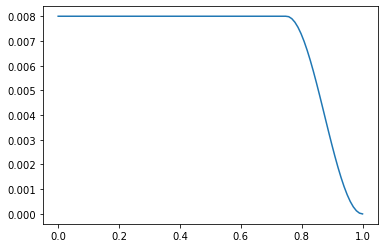

In [17]:
p = torch.linspace(0.,1,100)
f = combined_cos(0.75, LR, LR, LR/100000)
plt.plot(p, [f(o) for o in p]);

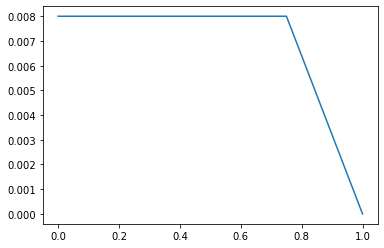

In [18]:
p = torch.linspace(0.,1,5)
f = combined_cos(0.75, LR, LR, LR/100000)
plt.plot(p, [f(o) for o in p]);

In [19]:
flat_cos = combined_cos(0.75, LR, LR, LR/100000)

In [20]:
current_batch = 1 

for epoch in range(NUM_EPOCHS):
    # training
    model.train()
    
    start = time.time()
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    
    for i, (images, target) in enumerate(train_loader):
        images = images.cuda(non_blocking=True) # non-blocking here with a single GPU will likely do nothing
        target = target.cuda(non_blocking=True) # non-blocking here makes sense - we can start
                                                          # doing something else before target is needed

        # compute output
        output = model(images)
        loss = criterion(output, target)
        
        # measure accuracy and record loss
        losses.update(loss.item(), images.size(0))
        acc1 = accuracy(output, target, topk=(1,))
        top1.update(acc1[0].item(), images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        new_lr = flat_cos(current_batch / (NUM_EPOCHS * len(train_loader)))
        optimizer.set_hyper('lr', new_lr)
        current_batch += 1
    
    # switch to evaluate mode
    model.eval()

    val_losses = AverageMeter('Loss', ':.4e')
    val_top1 = AverageMeter('Acc@1', ':6.2f')
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            val_losses.update(loss.item(), images.size(0))
            acc1 = accuracy(output, target, topk=(1,))
            val_top1.update(acc1[0].item(), images.size(0))
            
    # measure elapsed time
    end = time.time()
    elapsed = end - start
    
    print(f'{epoch+1}: * TrainLoss {losses.avg:.3f}  * TrainAcc@1 {top1.avg:.3f}  * ValLoss {val_losses.avg:.3f}  \
            * ValAcc@1 {val_top1.avg:.3f}  * Time {elapsed:.2f}')

1: * TrainLoss 1.597  * TrainAcc@1 54.557  * ValLoss 1.480              * ValAcc@1 60.713  * Time 68.00
2: * TrainLoss 1.216  * TrainAcc@1 71.254  * ValLoss 1.275              * ValAcc@1 70.217  * Time 64.98
3: * TrainLoss 1.087  * TrainAcc@1 76.946  * ValLoss 1.045              * ValAcc@1 79.720  * Time 65.06
4: * TrainLoss 0.997  * TrainAcc@1 80.885  * ValLoss 1.002              * ValAcc@1 81.045  * Time 65.09
5: * TrainLoss 0.849  * TrainAcc@1 87.454  * ValLoss 0.862              * ValAcc@1 86.930  * Time 65.12
